<a href="https://colab.research.google.com/github/amogh3892/3D-Biomedical-Image-Processing-Python-tutorial/blob/main/intro3DImageprocessingPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to 3D Image Processing using Python
Biomedical Image Processing (EBME 361/461)

**Amogh Hiremath**<br>
*Graduate Research Assistant*<br> 
*Center of Computational Imaging and Personalized Diagnostics (CCIPD)*<br> 
*Case Western Reserve University*


### Importing required libraries/modules

ITK is a cross-platform, open-source application development framework widely used for image processing tasks including image segmentation and image registration etc. SimpleITK provides a simplified interface to ITK in a variety of languages. Here we are using it in python.

For complete documentation, refer to [SimpleITK](https://simpleitk.readthedocs.io/en/master/gettingStarted.**html**)

Matplotlib library is used to plot/ display images.

In [1]:
!pip install SimpleITK
!pip install pyradiomics
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np 
from skimage import measure
from skimage.measure import regionprops
from radiomics import featureextractor
import os 
import six

### Reading 3D Volumes of prostate MRI

The SimpleITK ReadImage function supports reading of numerous image formats including but not limited to .nii, .nii.gz, .mha, .mhd, .nrrd ....

Reading a 3D Volume of prostate MRI..

In [2]:
img = sitk.ReadImage(f"T2W.nii.gz")

### Fundemental Attributes of SimpleITK image

Some of the important attributes; 

1. Origin (vector like type) - location in the world coordinate system of the voxel with all zero indexes.
2. Spacing (vector like type) - distance between pixels along each of the dimensions.
3. Size (vector like type) - number of pixels in each dimension.
4. Direction cosine matrix (vector like type representing matrix in row major order) - direction of each of the axes corresponding to the matrix columns.


For detailed documentation, please visit [Fundamental Concepts](https://simpleitk.readthedocs.io/en/master/fundamentalConcepts.html)


In [3]:
print(f"Image origin: {img.GetOrigin()}")
print(f"Image spacing: {img.GetSpacing()}")
print(f"Image size: {img.GetSize()}")
print(f"Direction cosine matrix: {img.GetDirection()}")

Image origin: (-57.6854362487793, -82.3630599975586, -27.08075714111328)
Image spacing: (0.5, 0.5, 3.000002145767212)
Image size: (384, 384, 19)
Direction cosine matrix: (0.9999992305342128, -0.00019930518052921863, 0.001224421740753051, -0.00019930518572633776, 0.948376457150748, 0.317146775513187, -0.0012244216698150598, -0.3171467417452689, 0.9483756763925301)


### Other attributes of SimpleITK image 

1. Dimension - Dimension of image</font>
2. Pixel Type - Type of pixel/voxel (uint, float ? ... )



In [4]:
print(f"Dimension: {img.GetDimension()}")
print(f"Pixel type: {img.GetPixelIDTypeAsString()}")

Dimension: 3
Pixel type: 16-bit unsigned integer


### Accessing pixel values in the image

For ex. Accessing pixel at the co-ordinate (150,150,10)

In [5]:
print(f"Value of pixel/voxel at co-ordinate (150,150,10): {img.GetPixel(150,150,10)}")

Value of pixel/voxel at co-ordinate (150,150,10): 91


### Displaying Image 

Displaying a particular 2D axial slice in the 3D volume. 
The best way to view images in python would be by converting the SimpleITK image to a numpy array. Then matplotlib library could be used to further display the images. 

Note 1: Changing from SimpleITK image to numpy image transposes the image. i.e (x,y,z) coordinates will become (z,y,x) in the numpy image.

Note 2: Changing from SimpleITK image to numpy image will lead to loss in the header information such as spacing, origin, direction ect. So converting back to SimpleITK image from numpy image will set the attributes to default values. 

In [6]:
# Converting SimpleITK image to numpy image using sitk.GetArrayFromImage() function
imgarr = sitk.GetArrayFromImage(img)

# Accessing 150,150,10 pixel from the numpy array. This time the numpy array is transposed. So, we have to access the pixels by (10, 150, 150)
print(f"Value of pixel/voxel at co-ordinate (150,150,10): {imgarr[10,150,150]}")

Value of pixel/voxel at co-ordinate (150,150,10): 91


(-0.5, 383.5, 383.5, -0.5)

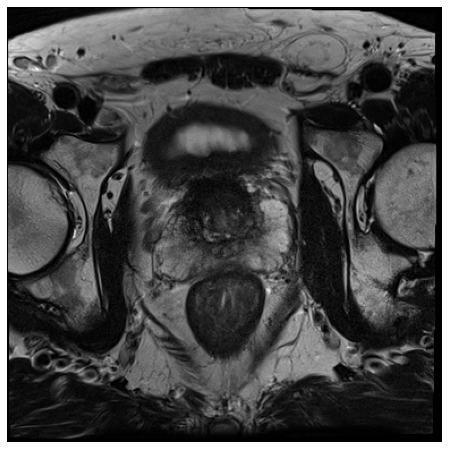

In [7]:
# Displaying the 10th axial slice of the 3D volume. 

fig = plt.figure(figsize=(8,8))
plt.imshow(imgarr[10],cmap='gray')
plt.axis('off')

In [8]:
# Note 2: Changing back to SimpleITK image from numpy will lead to loss of header information.
# sitk.GetImageFromArray() function can be used to convert from numpy array back to SimpleITK image.
imgFromNumpy = sitk.GetImageFromArray(imgarr)

print(f"Image origin: {imgFromNumpy.GetOrigin()} !!")
print(f"Image spacing: {imgFromNumpy.GetSpacing()} !!")
print(f"Direction cosine matrix: {imgFromNumpy.GetDirection()} !!")

Image origin: (0.0, 0.0, 0.0) !!
Image spacing: (1.0, 1.0, 1.0) !!
Direction cosine matrix: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) !!


**Note: Make sure all header information is reset after converting from SimpleITK image to numpy image**

In [9]:
# Resetting all the header information after converting from numpy 
imgFromNumpy.SetOrigin(img.GetOrigin())
imgFromNumpy.SetDirection(img.GetDirection())
imgFromNumpy.SetSpacing(img.GetSpacing())

print(f"Image origin: {imgFromNumpy.GetOrigin()}")
print(f"Image spacing: {imgFromNumpy.GetSpacing()}")
print(f"Direction cosine matrix: {imgFromNumpy.GetDirection()}")

Image origin: (-57.6854362487793, -82.3630599975586, -27.08075714111328)
Image spacing: (0.5, 0.5, 3.000002145767212)
Direction cosine matrix: (0.9999992305342128, -0.00019930518052921863, 0.001224421740753051, -0.00019930518572633776, 0.948376457150748, 0.317146775513187, -0.0012244216698150598, -0.3171467417452689, 0.9483756763925301)


### Resampling 3D Volume

Before analysing or extracting any features from an image, images have to be converted into a same resolution for the analysis to be uniform and make sense accross the dataset.

The following resampleimage function could be used to resample the image to a particular resolution. For ex. here we are resampling the image to a spacing of (1, 1 , 3) in x, y and z directions respectively. 


In [10]:
# Resampling images to a particular resolution 
def resampleimage(image, spacing, origin, interpolator = sitk.sitkLinear):
  """
  Resamples the image given spacing and the origin with a given interpolator 
  Default interpolator is Linear Interpolator ~ sitk.sitkLinear 
  Other interpolators : sitk.sitkNearestNeighbor , sitk.sitkBSpline,  sitk.sitkGaussian

  """
  new_size = tuple([int((image.GetSize()[i]*image.GetSpacing()[i])/spacing[i]) for i in range(len(spacing))])

  resampler = sitk.ResampleImageFilter()
  resampler.SetInterpolator(interpolator)
  resampler.SetOutputDirection(image.GetDirection())
  resampler.SetOutputOrigin(origin)
  resampler.SetOutputSpacing(spacing)
  resampler.SetSize(new_size)

  resampled = resampler.Execute(image)

  return resampled 


resampledImg = resampleimage(img,spacing = (1,1,3),origin= img.GetOrigin(), interpolator=sitk.sitkLinear)


print(f"Spacing before resampling: {img.GetSpacing()}")
print(f"Size before resampling: {img.GetSize()}")
print(f"Spacing after resampling: {resampledImg.GetSpacing()}")
print(f"Size after resampling: {resampledImg.GetSize()}")

Spacing before resampling: (0.5, 0.5, 3.000002145767212)
Size before resampling: (384, 384, 19)
Spacing after resampling: (1.0, 1.0, 3.0)
Size after resampling: (192, 192, 19)


Downsampling the image from 0.5 in x and y direction to 1 reduced the size of the image to half in those respective dimensions.  

### Overlaying prostate gland contour on the T2W MRI Image. 

PM.nii.gz provides the delineation of the prostate gland. Below code shows how to overlay the prostate mask on the T2W MRI image using matplotlib.


In [11]:
def overlay_mask(orgimg,masks,colors=None):
    """
    orgimg: The original image as numpy array (2D)
    masks: List of masks as numpy array (2D)
    colors: List of respective colors to plot

    """

    plt.figure(figsize=(5,5))
    plt.imshow(orgimg, cmap = 'gray')


    if colors is None:
      colors=cm.rainbow(np.linspace(0,1,len(masks)))

    for i,mask in enumerate(masks): 
      color = colors[i]
      contours = measure.find_contours(mask, 0)
      for n, contour in enumerate(contours):
          plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)

    plt.xticks([])
    plt.yticks([])

    return plt

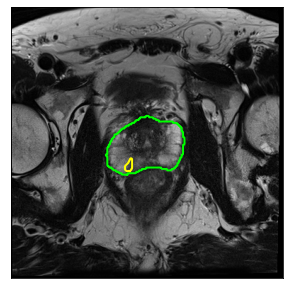

In [12]:
# Reading the prostate mask and lesion annotation
pm = sitk.ReadImage("PM.nii.gz")
ls = sitk.ReadImage("LS1.nii.gz")


# Converting the prostate mask and lesion annotation SimpleITK image to numpy array
pmarr = sitk.GetArrayFromImage(pm)
lsarr = sitk.GetArrayFromImage(ls)


# Plotting the overlay of mask on the T2W MRI image (8th slice)
slcno = 8 
plt = overlay_mask(imgarr[slcno],[pmarr[slcno],lsarr[slcno]],["lime","yellow"])


### Patch extraction 
Extracting patches based on the bounding box of the mask. This is important if we are only trying to analyze the region of interest. 

Bounding box co-ordinates: (155, 135, 237, 245)


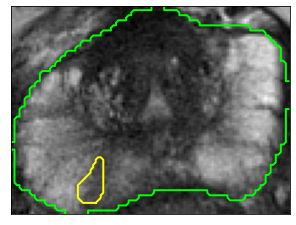

In [13]:
# Extracting the bounding box of the prostate in the 8th axial slice (Can also be done similar for a 3D bounding box.)
props = regionprops(pmarr[8])
starty, startx, endy, endx = props[0].bbox

print(f"Bounding box co-ordinates: {props[0].bbox}")

# Extracting the patch based on the bounding box. 
imgarrPatch = imgarr[:,starty:endy,startx:endx]
pmarrPatch = pmarr[:,starty:endy,startx:endx] 
lsarrPatch = lsarr[:,starty:endy,startx:endx]

slcno = 8 
plt = overlay_mask(imgarrPatch[slcno],[pmarrPatch[slcno],lsarrPatch[slcno]],["lime","yellow"])

### Morphological opearations using SimpleITK 

Example: Creating a peri-tumoral mask for the lesion. Let's say we want a peri-tumoral region around the periphey of the lesion with 6mm width. 

The spacing of T2W MRI in this example has a spacing of 0.5, There to obtain a peri-tumoral of 6mm width, we would first have to dilate 12 pixels and subtract the dilated image with the original one.  

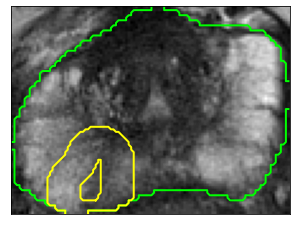

In [14]:

# Dilating 12 pixels wide 
dilatedls = sitk.BinaryDilate(ls,(12,12,0),sitk.sitkBall)

# Obtaining the peri-tumoral region 
perils = sitk.Subtract(dilatedls,ls)

# We try to contain the peri- tumoral mask within the prostate gland
perils = sitk.Mask(perils,pm)

# Converting to numpy array
perilsarr = sitk.GetArrayFromImage(perils)

# Obtaining patch from the peri- tumoral mask 
perilsarrPatch = perilsarr[:,starty:endy,startx:endx]


slcno = 8 
plt = overlay_mask(imgarrPatch[slcno],[pmarrPatch[slcno],perilsarrPatch[slcno]],["lime","yellow"])


### Feature extraction using pyradiomics

Extracting GLCM features using pyradiomics.
For detailed documentation visit the [Pyradiomics site](https://pyradiomics.readthedocs.io/en/latest/) 


In [15]:
# pyradiomics feature extractor requires some initial parameters to be set

params = {}
params['normalize'] = True
params['binWidth'] = 256
params['verbose'] = True

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**params) 

# First disablign all features and enabling only glcm features
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('glcm')

print("Enabled features:\n\t", extractor.enabledFeatures)  

print("Calculating features")
featureVector = extractor.execute(img, ls)

for featureName in featureVector.keys():
  print(f"Computed {featureName}: {featureVector[featureName]}")

Enabled features:
	 {'glcm': []}
Calculating features


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Computed diagnostics_Versions_PyRadiomics: v3.0.1
Computed diagnostics_Versions_Numpy: 1.19.5
Computed diagnostics_Versions_SimpleITK: 2.0.2
Computed diagnostics_Versions_PyWavelet: 1.1.1
Computed diagnostics_Versions_Python: 3.7.10
Computed diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 256, 'verbose': True}
Computed diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
Computed diagnostics_Image-original_Hash: 84186e21c5fe6484c47d030efc6934f8c7ebb9e7
Computed diagnostics_Image-original_Dimensionality: 3D
Computed diagnostics_Image-original_Spacing: (0.5, 0.5, 3.000002145767212)
Computed diagnostics_Image-original_Size: (384, 384, 19)
Computed diagn